# Balance of Evidence simulations. Positive Evidence Bias
### Tests for Matan Model Unequal Variance Model

In [1]:
import glam
import pandas as pd
import numpy as np
import numpy.matlib

import os.path
from statsmodels.stats.outliers_influence import summary_table
import matplotlib.patches as mpatches


/Users/pradyumna/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/pradyumna/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
import matplotlib.pyplot as plt

from scipy.stats import invgauss
import seaborn as sns
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
from scipy import stats
from scipy.stats.stats import pearsonr # Pearson's correlation
import statsmodels.api as sm

#import warnings
#warnings.filterwarnings('ignore')

In [3]:
np.random.seed(23) # from random.org

In [4]:
# For rpy2

import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


In [5]:
# For MacMini proper running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

In [7]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [8]:
%%R
library(lme4)
#library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)  # required for coefplot
library(multcomp)
library(pbkrtest)

## Custom functions

In [9]:
def balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats):
    
    mean_rts_trials = np.zeros((value_tests.shape[0])) * np.nan
    choice_trials = np.zeros((value_tests.shape[0])) * np.nan
    DEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    AbsDEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    Ev_drifts_0_trials  = []
    Ev_drifts_1_trials = []
    E0_last_trials = np.zeros((value_tests.shape[0])) * np.nan
    E1_last_trials = np.zeros((value_tests.shape[0])) * np.nan

    n_trials, n_items = value_tests.shape

    running_idx_value = 0
    #we iterate for all the combinations of trials + gaze
    for trial in range(n_trials):
        
            # intialize the drifts
            evidence_drifts_0 = []
            evidence_drifts_1 = []

            #define value and gaze values for this particular trial
            value_trial =value_tests[trial]
            gaze_trial =gaze_tests[trial]
            
            Sim_value = value_trial
            Sim_gaze = gaze_trial
            
            Delta_E = np.zeros(n_repeats) * np.nan            
            AbsDelta_E = np.zeros(n_repeats) * np.nan
            rts = np.zeros(n_repeats) * np.nan
            choices = np.zeros(n_repeats) * np.nan
            trial_idx = np.zeros(n_repeats) * np.nan
            repeat_idx = np.zeros(n_repeats) * np.nan
            running_idx = 0
        
            for repeat in range(n_repeats):
                    

                    
                    Evi_0, Evi_1, choice, rt = glam.driftSim_UneqVar.simulate_trial_drift(parameters, value_trial, gaze_trial,
                                                boundary=boundary,
                                                error_weight=error_weight,
                                                error_range=error_range, extra_s = 0)
                    
                    Delta_E[running_idx] = Evi_1[-1] - Evi_0[-1]
                    AbsDelta_E[running_idx] = abs(Evi_0[-1] - Evi_1[-1])                        
                    rts[running_idx] = rt
                    choices[running_idx] = choice
                    trial_idx[running_idx] = trial
                    repeat_idx[running_idx] = repeat
                    # Add a new sequence of drift for this particular trial
                    evidence_drifts_0.append(Evi_0)
                    evidence_drifts_1.append(Evi_1)
                    E0_last = Evi_0[-1]
                    E1_last = Evi_1[-1]
                    
                    running_idx += 1
                    
               
            # Add the mean value for this parameters interation               
            mean_rts_trials [running_idx_value] = rts.mean()
            choice_trials [running_idx_value]= choices.mean() 
            DEv_trials [running_idx_value] = Delta_E.mean()
            AbsDEv_trials [running_idx_value]= AbsDelta_E.mean()
            E0_last_trials[running_idx_value] = E0_last.mean()
            E1_last_trials[running_idx_value] = E1_last.mean()
            Ev_drifts_0_trials.append(evidence_drifts_0)
            Ev_drifts_1_trials.append(evidence_drifts_1)
 
            running_idx_value += 1 

    return AbsDEv_trials,mean_rts_trials,Ev_drifts_0_trials,Ev_drifts_1_trials,choice_trials,E0_last_trials,E1_last_trials

In [10]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

    
        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [11]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

In [12]:
def add_difficulty(df):
    """
    Compute trial difficulties and add to DataFrame.

    Maximum value -  other values.
    In the binary case, this reduces to abs(v0 - v1).

    Parameters
    ----------
    df :      <pandas DataFrame>
              Trial wise DataFrame containing columns for item_value_i
    """

    values = df[['LVal','RVal']].values
    values_sorted = np.sort(values, axis=1)
    difficulty = values_sorted[:, -1] - np.mean(values_sorted[:, :-1], axis=1)

    levels =  (np.max(difficulty) - np.min(difficulty))/10

    lev_label = np.arange(np.min(difficulty), np.max(difficulty) + levels,levels) 
    
    difficulty2= []
    for i in range(len(difficulty)):
         difficulty2.append( lev_label[ int(difficulty[i]//levels)] )
     
    difficulty = difficulty2
    
    df['difficulty'] = np.around(difficulty, decimals = 0)
    df['difficulty'] = difficulty
    
    return df.copy()

In [13]:
def plot_DEv_Conf(data, ax=None, xlims=(0, 10), xlabel_skip=2,color1 = '#4F6A9A',label1 = 'Like',label2 = 'GLAM Simulations'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 15))
        # Set seaborn style for the plot
        sns.set(style='white')

    df = data.copy()

    # Compute relevant variables
    df = add_difficulty(df)
    
    
    # select data to use
    
    data_labels = ['zConf_human','zAbsDEv']
    
    for i in range(len(data_labels)):
        # Compute summary statistics
        subject_means = df.groupby(['Part', 'difficulty'])[data_labels[i]].mean()
        means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
        sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]
    
        x = np.arange(len(means))
        
        # Add labels for scatter plot of mean rt per participant
        scatter_data = subject_means.reset_index()
        x_scatter = []
        group_labels = np.sort(scatter_data.difficulty.unique())
        for ii in range(len(scatter_data.difficulty.values)):
            a = scatter_data.difficulty.values[ii]
            position_item =  x[np.where(group_labels==a)[0][0]]
            x_scatter.append(position_item) 
        ## ********    
        
        predicted = False if i == 0 else True
        
        # Colors for predicted
        c_pred = [color1,'#606060','#607681' ]
        
        if not predicted:  # plot underlying data
            ax.plot(x, means, 'o', markerfacecolor=color1, markersize = 10, fillstyle = 'full',
                    color=color1, linewidth=1)
            ax.vlines(x, means - sems, means + sems,
                      linewidth=1, color= color1)
            jittr = np.random.uniform(low=-max(x)/20,high=max(x)/20,size=len(scatter_data))/2
            ax.plot(x_scatter+jittr, scatter_data[data_labels[i]].values, marker='o', ms=5, color=color1,alpha=0.3,linestyle="None")
    
        else:  # plot predictions
            ax.plot(x, means, '-o', markerfacecolor=c_pred[i],color=c_pred[i], linewidth=2.5, markersize = 10)

    #ax.set_ylim(2000, 3500)
    font_size_this = 40
    ax.set_xlabel('|ΔValue|',fontsize=font_size_this)
    ax.set_ylabel( r'zΔe / zConfidence',fontsize=font_size_this)
    ax.set_xticks(x[::xlabel_skip])
    ax.tick_params(axis = 'y',labelsize=font_size_this)
    ax.tick_params(axis = 'x',labelsize=font_size_this)

    ax.set_xticklabels(np.around(means.index.values[::xlabel_skip],decimals = 1))
    
    patch1 = mpatches.Patch(facecolor=color1,hatch=r'', label = label1)
    patch2 = mpatches.Patch(facecolor='#606060',hatch=r'', label = label2)

    leg = plt.legend(handles=[patch1,patch2],fontsize=25,loc = 'lower right')
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
    
    sns.despine()



In [14]:
def add_difficulty_TotVal(df,TotVal_label):
    """
    Compute trial difficulties and add to DataFrame.

    Maximum value -  other values.
    In the binary case, this reduces to abs(v0 - v1).

    Parameters
    ----------
    df :      <pandas DataFrame>
              Trial wise DataFrame containing columns for item_value_i
    """

    difficulty = df[[TotVal_label]].values

    levels =  (np.max(difficulty) - np.min(difficulty))/10

    lev_label = np.arange(np.min(difficulty), np.max(difficulty) + levels,levels) 
    
    difficulty2= []
    for i in range(len(difficulty)):
         difficulty2.append( lev_label[ int(difficulty[i]//levels)] )
     
    difficulty = difficulty2
    
    df['difficulty'] = np.around(difficulty, decimals = 0)
    df['difficulty'] = difficulty
    
    return df.copy()

In [15]:
def plot_DEv_Conf_TotVal(data, TotVal_label, ax=None, xlims=(0, 10), xlabel_skip=2,color1 = '#4F6A9A',label1 = 'Like',label2 = 'GLAM Simulations'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 15))
        # Set seaborn style for the plot
        sns.set(style='white')

    df = data.copy()

    # Compute relevant variables
    df = add_difficulty_TotVal(df,TotVal_label)
    print ('Done with TotVal')
    
    # select data to use
    
    data_labels = ['zConf_human','zAbsDEv']
    
    for i in range(len(data_labels)):
        # Compute summary statistics
        subject_means = df.groupby(['Part','difficulty'])[data_labels[i]].mean()
        means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
        sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]
    
        x = np.arange(len(means))
        
        # Add labels for scatter plot of mean rt per participant
        scatter_data = subject_means.reset_index()
        x_scatter = []
        group_labels = np.sort(scatter_data.difficulty.unique())
        for ii in range(len(scatter_data.difficulty.values)):
            a = scatter_data.difficulty.values[ii]
            position_item =  x[np.where(group_labels==a)[0][0]]
            x_scatter.append(position_item) 
        ## ********    
        
        predicted = False if i == 0 else True
        
        # Colors for predicted
        c_pred = [color1,'#606060','#607681' ]
        
        if not predicted:  # plot underlying data
            ax.plot(x, means, 'o', markerfacecolor=color1, markersize = 10, fillstyle = 'full',
                    color=color1, linewidth=1)
            ax.vlines(x, means - sems, means + sems,
                      linewidth=1, color= color1)
            jittr = np.random.uniform(low=-max(x)/20,high=max(x)/20,size=len(scatter_data))/2
            ax.plot(x_scatter+jittr, scatter_data[data_labels[i]].values, marker='o', ms=5, color=color1,alpha=0.3,linestyle="None")
    
        else:  # plot predictions
            ax.plot(x, means, '-o', markerfacecolor=c_pred[i],color=c_pred[i], linewidth=2.5, markersize = 10)
    font_size_this = 40
    #ax.set_ylim(2000, 3500)
    ax.set_xlabel('|ΣValue|',fontsize=font_size_this)
    ax.set_ylabel( r'zΔe / zConfidence',fontsize=font_size_this)
    ax.set_xticks(x[::xlabel_skip])
    ax.tick_params(axis = 'y',labelsize=font_size_this)
    ax.tick_params(axis = 'x',labelsize=font_size_this)
    ax.set_xticklabels(np.around(means.index.values[::xlabel_skip],decimals = 1))
    
    patch1 = mpatches.Patch(facecolor=color1,hatch=r'', label = label1)
    patch2 = mpatches.Patch(facecolor='#606060',hatch=r'', label = label2)

    leg = plt.legend(handles=[patch1,patch2],fontsize=25,loc = 'lower right')
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
    
    sns.despine()


## Define some parameters for the simulations


In [16]:
# Parameters for the simulations
boundary=1
error_weight=0.05

## Load data from study to use DValue as reference for the simulations
Used no bins data for simulation. Value for dislike frames is already inverted

In [17]:
data = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Like_NoBin_31.csv'))
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

data2 = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Dislike_NoBin_Inv_31.csv'))
# Subset only necessary columns
data2 = data2[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

In [18]:
# Load data for FF2018 study 

# Like condition 

data_all0 = pd.read_csv('data/FF2018_data/DataFoodFramingNotebook_31.csv')
data_all0 = data_all0.drop(['Unnamed: 0'], axis=1)
data_all = data_all0.loc[data_all0['BlockCond'] == 1] # 1 = Like, 2 = Dislike

data_all=data_all.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

# Dislike condition

data_all2 = data_all0.loc[data_all0['BlockCond'] == 2] # 1 = Like, 2 = Dislike

data_all2=data_all2.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

## Load parameter estimates for participants


Use the parameter estimates from GLAM fit for Like, Binned data

In [19]:
sufix = 'individual_Like_NoBin_Gamma-11_NUTS_31'
glam_full = glam.GLAM(data)
glam_full.estimates = np.load(str('results/estimates/glam_FF2019_full_'+sufix+'.npy'))

# generate dataframe with new params
params_part_like = pd.DataFrame()
for i in range(len(glam_full.estimates)):    
    params_part_like1 = pd.DataFrame.from_dict(glam_full.estimates.item(i))
    params_part_like = pd.concat([params_part_like ,params_part_like1])
    
params_part_like = params_part_like.reset_index(drop=True)

params_part = params_part_like
params_part

,b,p_error,v,gamma,SNR,s,tau,t0
0,1.0,0.05,0.000044,0.01,179.94,0.007742,4.77,0.0
1,1.0,0.05,0.000075,0.80,44.31,0.005750,0.56,0.0
2,1.0,0.05,0.000057,0.14,107.97,0.008394,1.87,0.0
3,1.0,0.05,0.000042,-0.05,174.89,0.007141,4.70,0.0
4,1.0,0.05,0.000091,0.05,73.46,0.006764,2.34,0.0
5,1.0,0.05,0.000064,0.38,107.44,0.007028,1.45,0.0
6,1.0,0.05,0.000077,0.01,116.09,0.009647,2.22,0.0
7,1.0,0.05,0.000043,0.07,152.56,0.007672,1.60,0.0
8,1.0,0.05,0.000055,-0.88,174.54,0.009078,1.04,0.0
9,1.0,0.05,0.000046,0.25,170.19,0.008060,4.81,0.0


### Use only median parameters to run the simulations

In [20]:
params_part_median = pd.DataFrame()
params_part_median = pd.concat([params_part_median ,params_part.median()])
params_part_median = params_part_median.T

## --------------------------

# Run drift simulations for selected values and parameters

In [21]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 1 # Repeat outside the accumulator function
#gaze_out = 1 # We DO want to use the gaze from the particpants (1 to remove)

In [22]:
if not os.path.exists(str('results_extra/simulations_evidence/DEvidence_simulations_PEBTest.csv')):  
    
    Part_number = []
    LVal = []
    RVal = []
    LGaze = []
    RGaze = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    E0choice = []
    E1choice = []
    gaze_out_sim = []

    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
    
    part_id = data_all['Part'].unique()

    for gaze_out in [0,1]:
      for i in range(len(part_id)):    
        for k in range(0,repeat_extra) :
            PartData = data.loc[data['subject'] == i] # dataframe including participant GLAM data
            PartDataAll = data_all.loc[data_all['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
                print('nobias')
            else:
                gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))
                print('bias')

            # We keep the same parameters for this case. 
            gamma = 1
            tau = params_part_median['tau'][0]
            v = params_part_median['v'][0]
            s = params_part_median['s'][0]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices,E0_last,E1_last = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            LGaze_tmp = [item[0] for item in gaze_tests]
            RGaze_tmp = [item[1] for item in gaze_tests]
            
            
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                
                LGaze.append(LGaze_tmp[j])
                RGaze.append(RGaze_tmp[j])
                
                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])
                E0choice.append(E0_last[j])
                E1choice.append(E1_last[j])
                gaze_out_sim.append(gaze_out)
                


        print ("subj " + str(i))
        
    data_simulation =  pd.DataFrame()
    data_simulation["Part"] = Part_number
    data_simulation["LVal"] = LVal
    data_simulation["RVal"] = RVal
    data_simulation["LGaze"] = LGaze
    data_simulation["RGaze"] = RGaze
    data_simulation["AbsDVal"] = absDVal
    data_simulation["TotVal"] = TotVal
    data_simulation["AbsDEv"] = AbsDEvid
    data_simulation["RTsim"] = RT_sim
    data_simulation["GazeOut"] = gaze_out_sim
    data_simulation["E0choice"] = E0choice
    data_simulation["E1choice"] = E1choice
    data_simulation["Correct_sim"] = Correct_sim
    data_simulation["Choice_sim"] = Choice_sim
    data_simulation["Conf_human"] = Conf_human
    data_simulation["zConf_human"] = zConf_human
    
    data_simulation["zLVal"] = z_score1(data_simulation,'Part',"LVal")
    data_simulation["zRVal"] = z_score1(data_simulation,'Part',"RVal")
    data_simulation["zAbsDVal"] = z_score1(data_simulation,'Part',"AbsDVal")
    data_simulation["zTotVal"] = z_score1(data_simulation,'Part',"TotVal")
    data_simulation["zAbsDEv"] = z_score1(data_simulation,'Part',"AbsDEv")
    data_simulation["zRTsim"] = z_score1(data_simulation,'Part',"RTsim")

bias
subj 0
bias
subj 1
bias
subj 2
bias
subj 3
bias
subj 4
bias
subj 5
bias
subj 6
bias
subj 7
bias
subj 8
bias
subj 9
bias
subj 10
bias
subj 11
bias
subj 12
bias
subj 13
bias
subj 14
bias
subj 15
bias
subj 16
bias
subj 17
bias
subj 18
bias
subj 19
bias
subj 20
bias
subj 21
bias
subj 22
bias
subj 23
bias
subj 24
bias
subj 25
bias
subj 26
bias
subj 27
bias
subj 28
bias
subj 29
bias
subj 30
nobias
subj 0
nobias
subj 1
nobias
subj 2
nobias
subj 3
nobias
subj 4
nobias
subj 5
nobias
subj 6
nobias
subj 7
nobias
subj 8
nobias
subj 9
nobias
subj 10
nobias
subj 11
nobias
subj 12
nobias
subj 13
nobias
subj 14
nobias
subj 15
nobias
subj 16
nobias
subj 17
nobias
subj 18
nobias
subj 19
nobias
subj 20
nobias
subj 21
nobias
subj 22
nobias
subj 23
nobias
subj 24
nobias
subj 25
nobias
subj 26
nobias
subj 27
nobias
subj 28
nobias
subj 29
nobias
subj 30


In [23]:
#if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv')):   
#        data_simulation.to_csv(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv'))

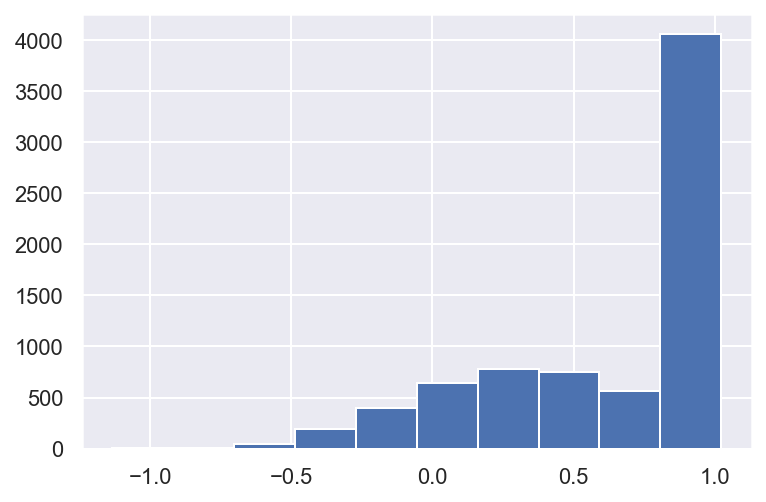

In [25]:
data_simulation.E0choice.hist()

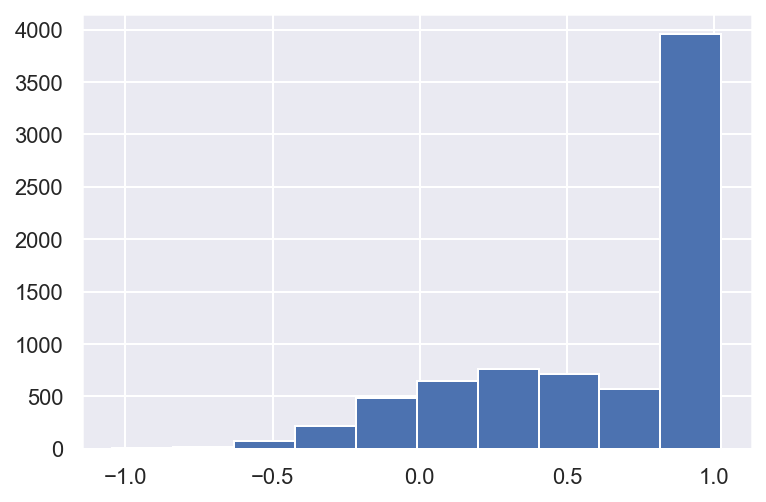

In [26]:
data_simulation.E1choice.hist()

In [39]:
#correl_plot(data_simulation,'AbsDEv', "AbsDEv",'Conf_human','Conf_human')
#correl_plot(data_simulation,'zAbsDEv', "zAbsDEv",'zConf_human','zConf_human')

## if gaze_out = 1, then gaze is equal for both items

In [35]:
data_simulation.loc[data_simulation['GazeOut']== 0].AbsDEv.mean()

0.7000151582009826

In [36]:
data_simulation.loc[data_simulation['GazeOut']== 1].AbsDEv.mean()

0.7091442636507359

In [37]:
data_simulation['Part'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [38]:
def plot_biasNoBias_std(data_simulation, label_interest,label_order ):

    fig, ax = plt.subplots(figsize=(7, 7))
    # Set seaborn style for the plot
    sns.set(style='white')
    
    color1 = 'b'
    #we extract the standard deviation for the data
    subject_means = data_simulation.groupby(["Part",label_order])[label_interest].std()
    means = subject_means.groupby(label_order).mean()
    sems = subject_means.groupby(label_order).sem()
    x = np.arange(len(means))
    
    scatter_data = subject_means.reset_index()
    x_scatter = []
    group_labels = np.sort(scatter_data[label_order].unique())
    for ii in range(len(scatter_data[label_order].values)):
        a = scatter_data[label_order].values[ii]
        position_item =  x[np.where(group_labels==a)[0][0]]
        x_scatter.append(position_item) 
    
    ax.plot(x, means, 'o', markerfacecolor=color1, markersize = 10, fillstyle = 'full',
              color=color1, linewidth=1)
    ax.vlines(x, means - sems, means + sems,
                linewidth=1, color= color1)
    jittr = np.random.uniform(low=-max(x)/20,high=max(x)/20,size=len(scatter_data))/2
    ax.plot(x_scatter+jittr, scatter_data[label_interest].values, marker='o', ms=5, color=color1,alpha=0.3,linestyle="None")
    
    
    ## extras figure
        #ax.set_ylim(2000, 3500)
    font_size_this = 20
    ax.set_xlabel(label_order,fontsize=font_size_this)
    ax.set_ylabel( label_interest,fontsize=font_size_this)
    #ax.set_xticks(x[::xlabel_skip])
    ax.tick_params(axis = 'y',labelsize=font_size_this)
    ax.tick_params(axis = 'x',labelsize=font_size_this)
    
    #ax.set_xticklabels(np.around(means.index.values[::xlabel_skip],decimals = 1))
    
    #patch1 = mpatches.Patch(facecolor=color1,hatch=r'', label = label1)
    #patch2 = mpatches.Patch(facecolor='#606060',hatch=r'', label = label2)
    
    #leg = plt.legend(handles=[patch1,patch2],fontsize=25,loc = 'lower right')
    #leg.get_frame().set_facecolor('none')
    #leg.get_frame().set_linewidth(0.0)
    
    sns.despine()


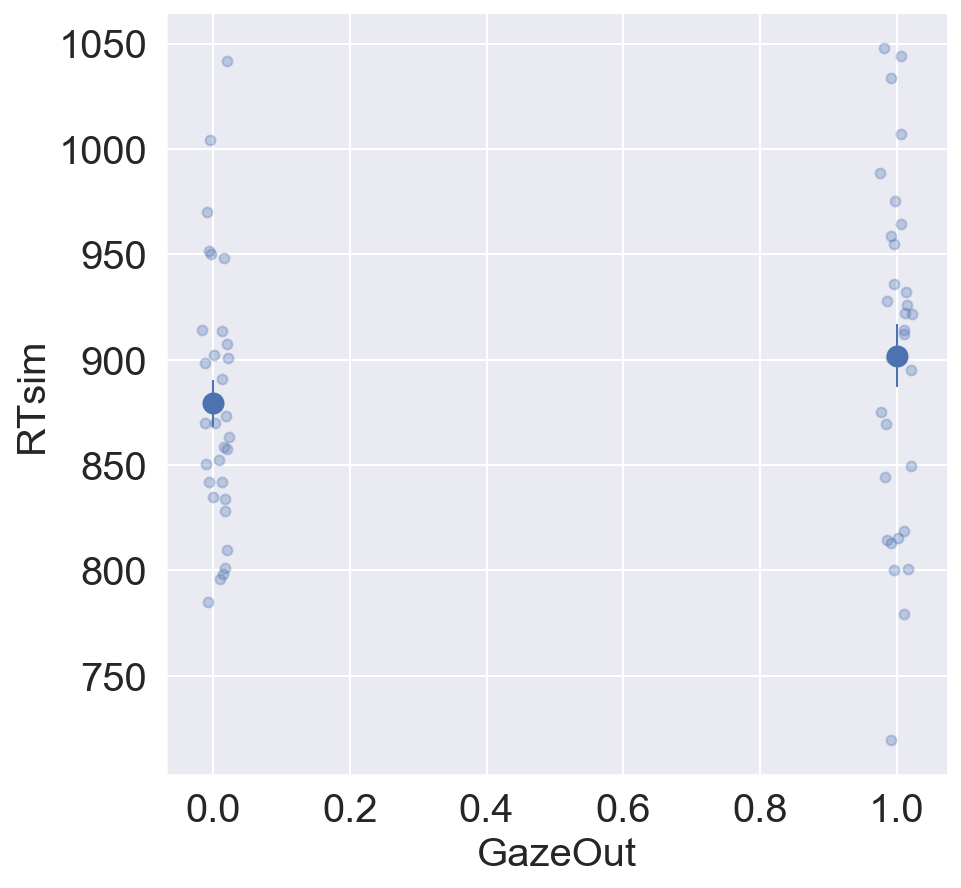

In [39]:
## 1 is no bias
label_interest = 'RTsim'
label_order = 'GazeOut'
plot_biasNoBias_std(data_simulation, label_interest,label_order )

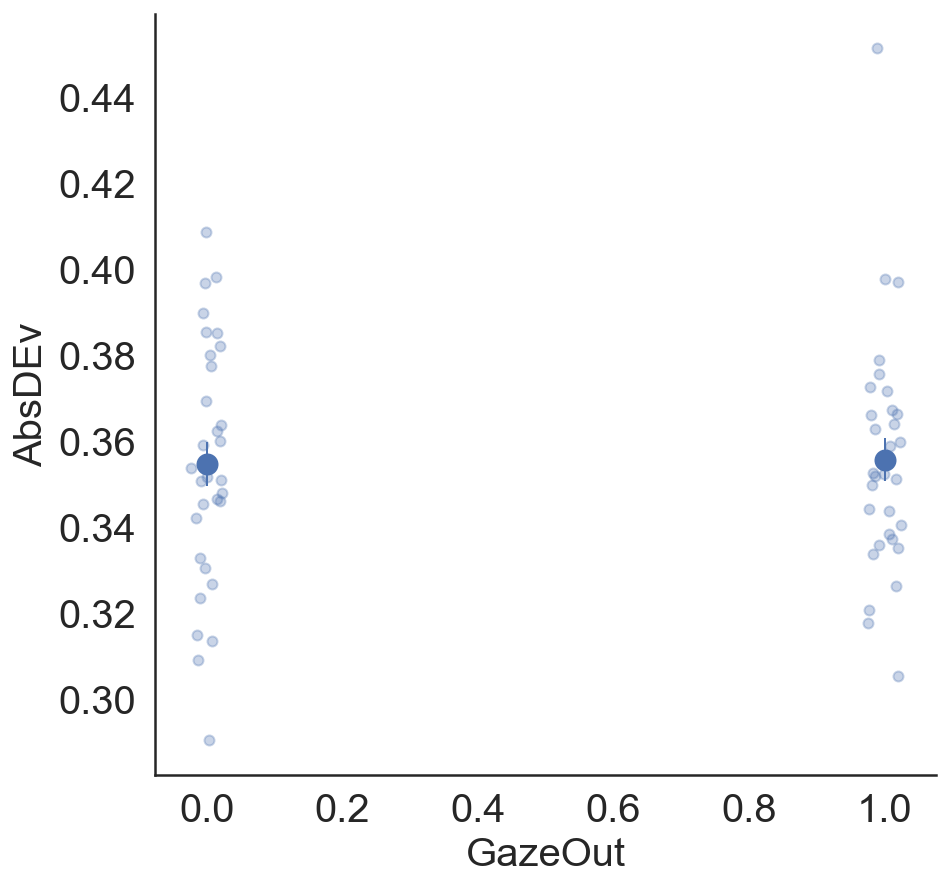

In [40]:
## 1 is no bias
label_interest = 'AbsDEv'
label_order = 'GazeOut'
plot_biasNoBias_std(data_simulation, label_interest,label_order )

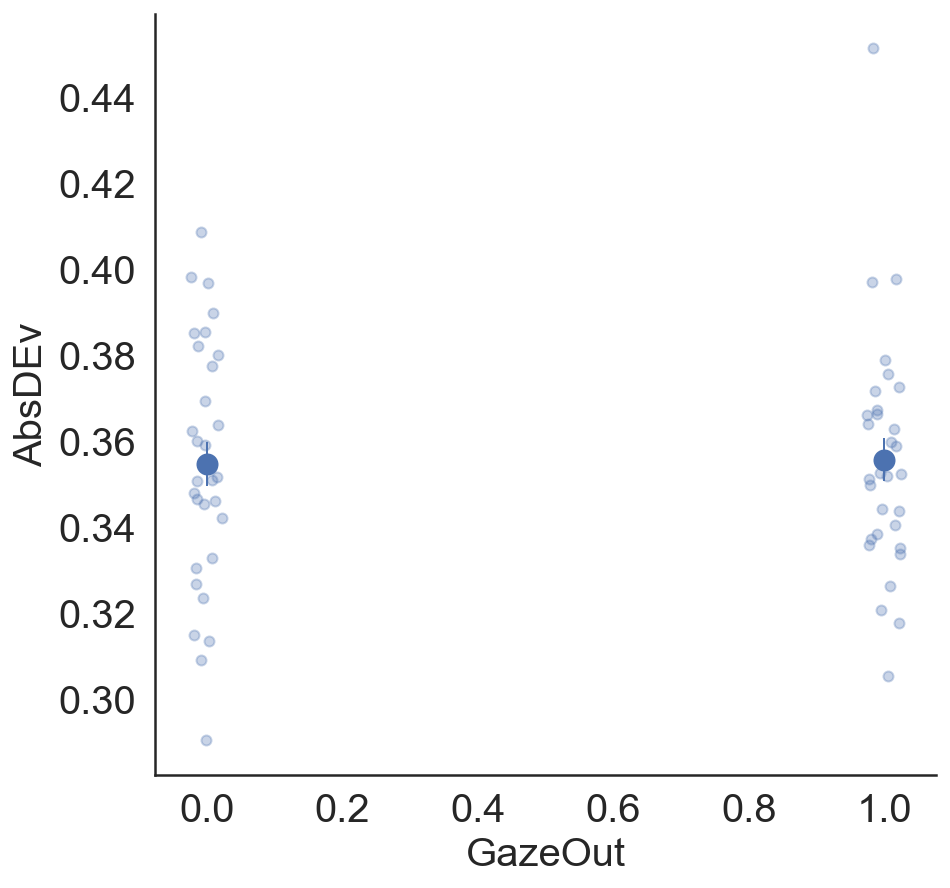

In [41]:
## 1 is no bias
label_interest = 'AbsDEv'
label_order = 'GazeOut'
plot_biasNoBias_std(data_simulation, label_interest,label_order )

## Plot variability for the bias case, for the high gaze vs low gaze options.

In [53]:
data_sim_bias = data_simulation.loc[data_simulation['GazeOut']== 0].copy()

In [46]:
data_sim_bias.columns

Index(['Part', 'LVal', 'RVal', 'LGaze', 'RGaze', 'AbsDVal', 'TotVal', 'AbsDEv',
       'RTsim', 'GazeOut', 'E0choice', 'E1choice', 'Correct_sim', 'Choice_sim',
       'Conf_human', 'zConf_human', 'zLVal', 'zRVal', 'zAbsDVal', 'zTotVal',
       'zAbsDEv', 'zRTsim'],
      dtype='object')

In [60]:
data_sim_bias['E_highGaze'] = (data_sim_bias['LGaze'] >= data_sim_bias['RGaze']) * data_sim_bias['E0choice'] + (data_sim_bias['LGaze'] < data_sim_bias['RGaze']) * data_sim_bias['E1choice']
data_sim_bias['E_lowGaze'] = (data_sim_bias['LGaze'] <= data_sim_bias['RGaze']) * data_sim_bias['E0choice'] + (data_sim_bias['LGaze'] > data_sim_bias['RGaze']) * data_sim_bias['E1choice']

/Users/pradyumna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/Users/pradyumna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


E low distribution: mean =0.5591506538679615; std = 0.454331867066654
E high distribution: mean =0.749555630031856; std = 0.3880575118958915


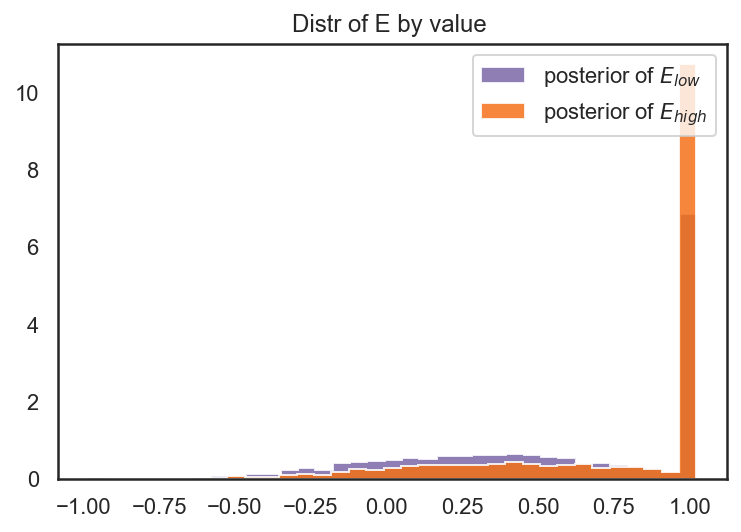

In [66]:
plt.hist(data_sim_bias['E_lowGaze'], histtype='stepfilled', bins=35, alpha=0.85,
                 label=r"posterior of $E_{low}$", color="#7A68A6", normed=True)
plt.hist(data_sim_bias['E_highGaze'], histtype='stepfilled', bins=35, alpha=0.85,
                 label=r"posterior of $E_{high}$", color="#F47118", normed=True)
plt.title(r"Distr of E by value ")

plt.legend()
#plt.show()

print('E low distribution: mean ='+ str(np.mean(data_sim_bias['E_lowGaze'])) +  '; std = ' + str(np.std(data_sim_bias['E_lowGaze']))) 
print('E high distribution: mean ='+ str(np.mean(data_sim_bias['E_highGaze'])) +  '; std = ' + str(np.std(data_sim_bias['E_highGaze']))) 
    

### ----------------------------------

## Check if what happens if we simulate the independent gaze and independent values, non identical to the ones used to train the models

## we generate a new dataframe in which item_value_0, item_value_1, gaze_0 and gaze_1 are all scrambled.

In [143]:
data_shuffle = data.copy()

In [144]:
data_shuffle = data_shuffle.drop(columns=['item_value_0', 'item_value_1','gaze_0','gaze_1'])
data_shuffle.head()

,subject,trial,choice,rt
0,0,0,0,2009
1,0,1,0,3371
2,0,2,1,1700
3,0,3,1,7466
4,0,4,1,1889


In [145]:
data_shuffle.head()

,subject,trial,choice,rt
0,0,0,0,2009
1,0,1,0,3371
2,0,2,1,1700
3,0,3,1,7466
4,0,4,1,1889


In [146]:
data.head()

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,0,0,0,2009,1.10,0.95,0.568396,0.431604
1,0,1,0,3371,2.00,1.70,0.762332,0.237668
2,0,2,1,1700,1.10,2.30,0.446809,0.553191
3,0,3,1,7466,1.25,1.40,0.532352,0.467648
4,0,4,1,1889,2.00,2.30,0.529736,0.470264


In [147]:
data_shuffle['item_value_0'] = np.random.permutation(data['item_value_0'].values)
data_shuffle['item_value_1'] = np.random.permutation(data['item_value_1'].values)
data_shuffle['gaze_0'] = np.random.permutation(data['gaze_0'].values)
data_shuffle['gaze_1'] = 1 - data_shuffle['gaze_0']

In [148]:
data_shuffle.head()

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,0,0,0,2009,0.95,0.80,0.601022,0.398978
1,0,1,0,3371,3.00,0.80,0.493300,0.506700
2,0,2,1,1700,1.40,1.10,0.545003,0.454997
3,0,3,1,7466,0.80,0.65,0.655961,0.344039
4,0,4,1,1889,0.65,0.65,0.408511,0.591489


#### re-run simulations 

In [149]:
gaze_out = 0
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 1 # Repeat outside the accumulator function

if not os.path.exists(str('results_extra/simulations_evidence/DEvidence_simulations_PEBTest_indepGazeValue.csv')):  
    
    Part_number = []
    LVal = []
    RVal = []
    LGaze = []
    RGaze = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    E0choice = []
    E1choice = []
    gaze_out_sim = []

    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
    
    part_id = data_all['Part'].unique()

    for gaze_out in [0,1]:
      for i in range(len(part_id)):    
        for k in range(0,repeat_extra) :
            PartData = data_shuffle.loc[data_shuffle['subject'] == i] # dataframe including participant GLAM data
            #PartDataAll = data_all.loc[data_all['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            #conf_tests =PartDataAll['Conf'].values
            #zconf_tests =PartDataAll['zConf'].values
            
            
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
                print('nobias')
            else:
                gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))
                print('bias')

            # We keep the same parameters for this case. 
            gamma = params_part_median['gamma'][0]
            tau = params_part_median['tau'][0]
            v = params_part_median['v'][0]
            s = params_part_median['s'][0]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices,E0_last,E1_last = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            LGaze_tmp = [item[0] for item in gaze_tests]
            RGaze_tmp = [item[1] for item in gaze_tests]
            
            
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                #Conf_human.append(conf_tests[j])
                #zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                
                LGaze.append(LGaze_tmp[j])
                RGaze.append(RGaze_tmp[j])
                
                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])
                E0choice.append(E0_last[j])
                E1choice.append(E1_last[j])
                gaze_out_sim.append(gaze_out)
                


        print ("subj " + str(i))
        
    data_simulation =  pd.DataFrame()
    data_simulation["Part"] = Part_number
    data_simulation["LVal"] = LVal
    data_simulation["RVal"] = RVal
    data_simulation["LGaze"] = LGaze
    data_simulation["RGaze"] = RGaze
    data_simulation["AbsDVal"] = absDVal
    data_simulation["TotVal"] = TotVal
    data_simulation["AbsDEv"] = AbsDEvid
    data_simulation["RTsim"] = RT_sim
    data_simulation["GazeOut"] = gaze_out_sim
    data_simulation["E0choice"] = E0choice
    data_simulation["E1choice"] = E1choice
    data_simulation["Correct_sim"] = Correct_sim
    data_simulation["Choice_sim"] = Choice_sim
    #data_simulation["Conf_human"] = Conf_human
    #data_simulation["zConf_human"] = zConf_human
    
    data_simulation["zLVal"] = z_score1(data_simulation,'Part',"LVal")
    data_simulation["zRVal"] = z_score1(data_simulation,'Part',"RVal")
    data_simulation["zAbsDVal"] = z_score1(data_simulation,'Part',"AbsDVal")
    data_simulation["zTotVal"] = z_score1(data_simulation,'Part',"TotVal")
    data_simulation["zAbsDEv"] = z_score1(data_simulation,'Part',"AbsDEv")
    data_simulation["zRTsim"] = z_score1(data_simulation,'Part',"RTsim")

bias
subj 0
bias
subj 1
bias
subj 2
bias
subj 3
bias
subj 4
bias
subj 5
bias
subj 6
bias
subj 7
bias
subj 8
bias
subj 9
bias
subj 10
bias
subj 11
bias
subj 12
bias
subj 13
bias
subj 14
bias
subj 15
bias
subj 16
bias
subj 17
bias
subj 18
bias
subj 19
bias
subj 20
bias
subj 21
bias
subj 22
bias
subj 23
bias
subj 24
bias
subj 25
bias
subj 26
bias
subj 27
bias
subj 28
bias
subj 29
bias
subj 30
nobias
subj 0
nobias
subj 1
nobias
subj 2
nobias
subj 3
nobias
subj 4
nobias
subj 5
nobias
subj 6
nobias
subj 7
nobias
subj 8
nobias
subj 9
nobias
subj 10
nobias
subj 11
nobias
subj 12
nobias
subj 13
nobias
subj 14
nobias
subj 15
nobias
subj 16
nobias
subj 17
nobias
subj 18
nobias
subj 19
nobias
subj 20
nobias
subj 21
nobias
subj 22
nobias
subj 23
nobias
subj 24
nobias
subj 25
nobias
subj 26
nobias
subj 27
nobias
subj 28
nobias
subj 29
nobias
subj 30


In [150]:
data_simulation

,Part,LVal,RVal,LGaze,RGaze,AbsDVal,TotVal,AbsDEv,RTsim,GazeOut,E0choice,E1choice,Correct_sim,Choice_sim,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,0.95,0.80,0.601022,0.398978,0.15,1.75,1.494272,3457.0,0,1.007617,-0.486654,1,0.0,-0.005055,-0.373682,-0.943712,-0.246185,2.491769,0.912291
1,0,3.00,0.80,0.493300,0.506700,2.20,3.80,1.028228,2035.0,0,1.005480,-0.022748,1,0.0,2.758101,-0.373682,2.307732,1.820757,1.167358,-0.537317
2,0,1.40,1.10,0.545003,0.454997,0.30,2.50,0.124213,2493.0,0,1.006181,0.881968,1,0.0,0.601492,0.092611,-0.705801,0.510014,-1.401686,-0.070425
3,0,0.80,0.65,0.655961,0.344039,0.15,1.45,0.709255,1627.0,0,1.004775,0.295521,1,0.0,-0.207237,-0.606828,-0.943712,-0.548664,0.260894,-0.953238
4,0,0.65,0.65,0.408511,0.591489,0.00,1.30,0.203795,2068.0,0,1.000777,0.796983,0,0.0,-0.409419,-0.606828,-1.181622,-0.699903,-1.175530,-0.503676
5,0,0.20,0.65,0.312524,0.687476,0.45,0.85,0.419934,1572.0,0,1.010173,0.590239,0,0.0,-1.015965,-0.606828,-0.467891,-1.153622,-0.561301,-1.009306
6,0,0.05,2.45,0.281781,0.718219,2.40,2.50,1.521909,1873.0,0,-0.508744,1.013166,1,1.0,-1.218147,2.190927,2.624946,0.510014,2.570310,-0.702462
7,0,0.95,1.10,0.562344,0.437656,0.15,2.05,0.498577,1683.0,0,0.509221,1.007798,1,1.0,-0.005055,0.092611,-0.943712,0.056295,-0.337811,-0.896151
8,0,0.00,2.00,0.303384,0.696616,2.00,2.00,0.861524,1094.0,0,0.141821,1.003344,1,1.0,-1.285541,1.491488,1.990518,0.005882,0.693615,-1.496586
9,0,0.50,1.25,0.506612,0.493388,0.75,1.75,0.438114,3422.0,0,0.565006,1.003120,1,1.0,-0.611601,0.325757,0.007930,-0.246185,-0.509639,0.876612


In [151]:
%%R -i data_simulation
d <- data_simulation

In [152]:
%%R
data_sim_gazeOut <- d[ which(d$GazeOut==1), ]
data_sim_gazeIn <- d[ which(d$GazeOut==0), ]


## regresions for DEv using non-biased simulations (GazeOut)

BIC: 9988.068
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal + zRTsim, data = data_sim_gazeOut)

Coefficients:
(Intercept)     zAbsDVal      zTotVal       zRTsim  
  -0.001126     0.282254     0.032225    -0.195945  

Degrees of Freedom: 3719 Total (i.e. Null);  3716 Residual
Null Deviance:	    3723 
Residual Deviance: 3157 	AIC: 9957


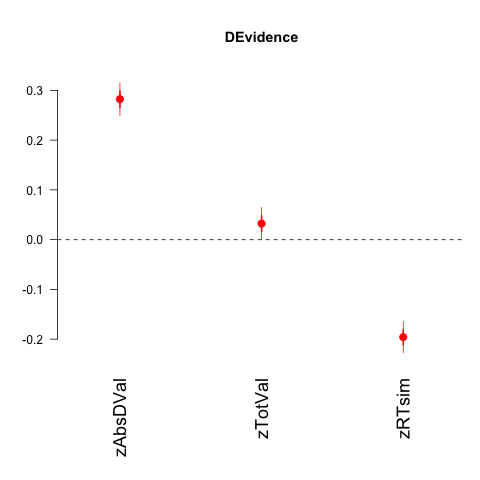

In [153]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal + zRTsim  , data= data_sim_gazeOut)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

In [154]:
## regresions for DEv using biased, but randomly assigned gaze simulations (GazeIn)

BIC: 9946.637
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal + zRTsim, data = data_sim_gazeIn)

Coefficients:
(Intercept)     zAbsDVal      zTotVal       zRTsim  
   0.001126     0.269187     0.047192    -0.212660  

Degrees of Freedom: 3719 Total (i.e. Null);  3716 Residual
Null Deviance:	    3717 
Residual Deviance: 3122 	AIC: 9916


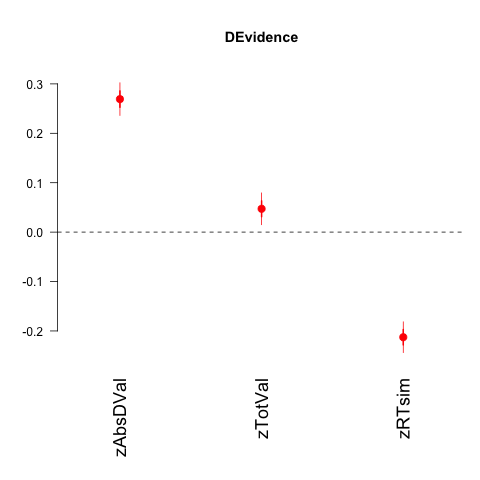

In [155]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal + zRTsim  , data= data_sim_gazeIn)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

## if we scramble the gaze and generate "artificial" combinations of gaze and value (e.g. gaze not going to the higher value in like frame), we observe something similar to the case wihout gaze bias

# % ----[END]

In [156]:
# We calculate the original regression with human data

In [28]:
%%R -i data_all
d <- data_all

BIC: 9752.417
Call:  glm(formula = zConf ~ zAbsDVal + zTotVal + zRT, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal          zRT  
    0.07449      0.14002      0.08652     -0.26744  

Degrees of Freedom: 3719 Total (i.e. Null);  3716 Residual
Null Deviance:	    3353 
Residual Deviance: 2964 	AIC: 9721


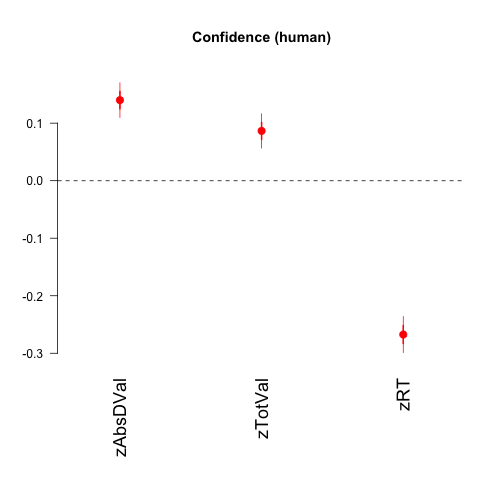

In [29]:
%%R    
title_plot = "Confidence (human)"
ModelChoice_1 <- glm(zConf ~ zAbsDVal + zTotVal + zRT  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

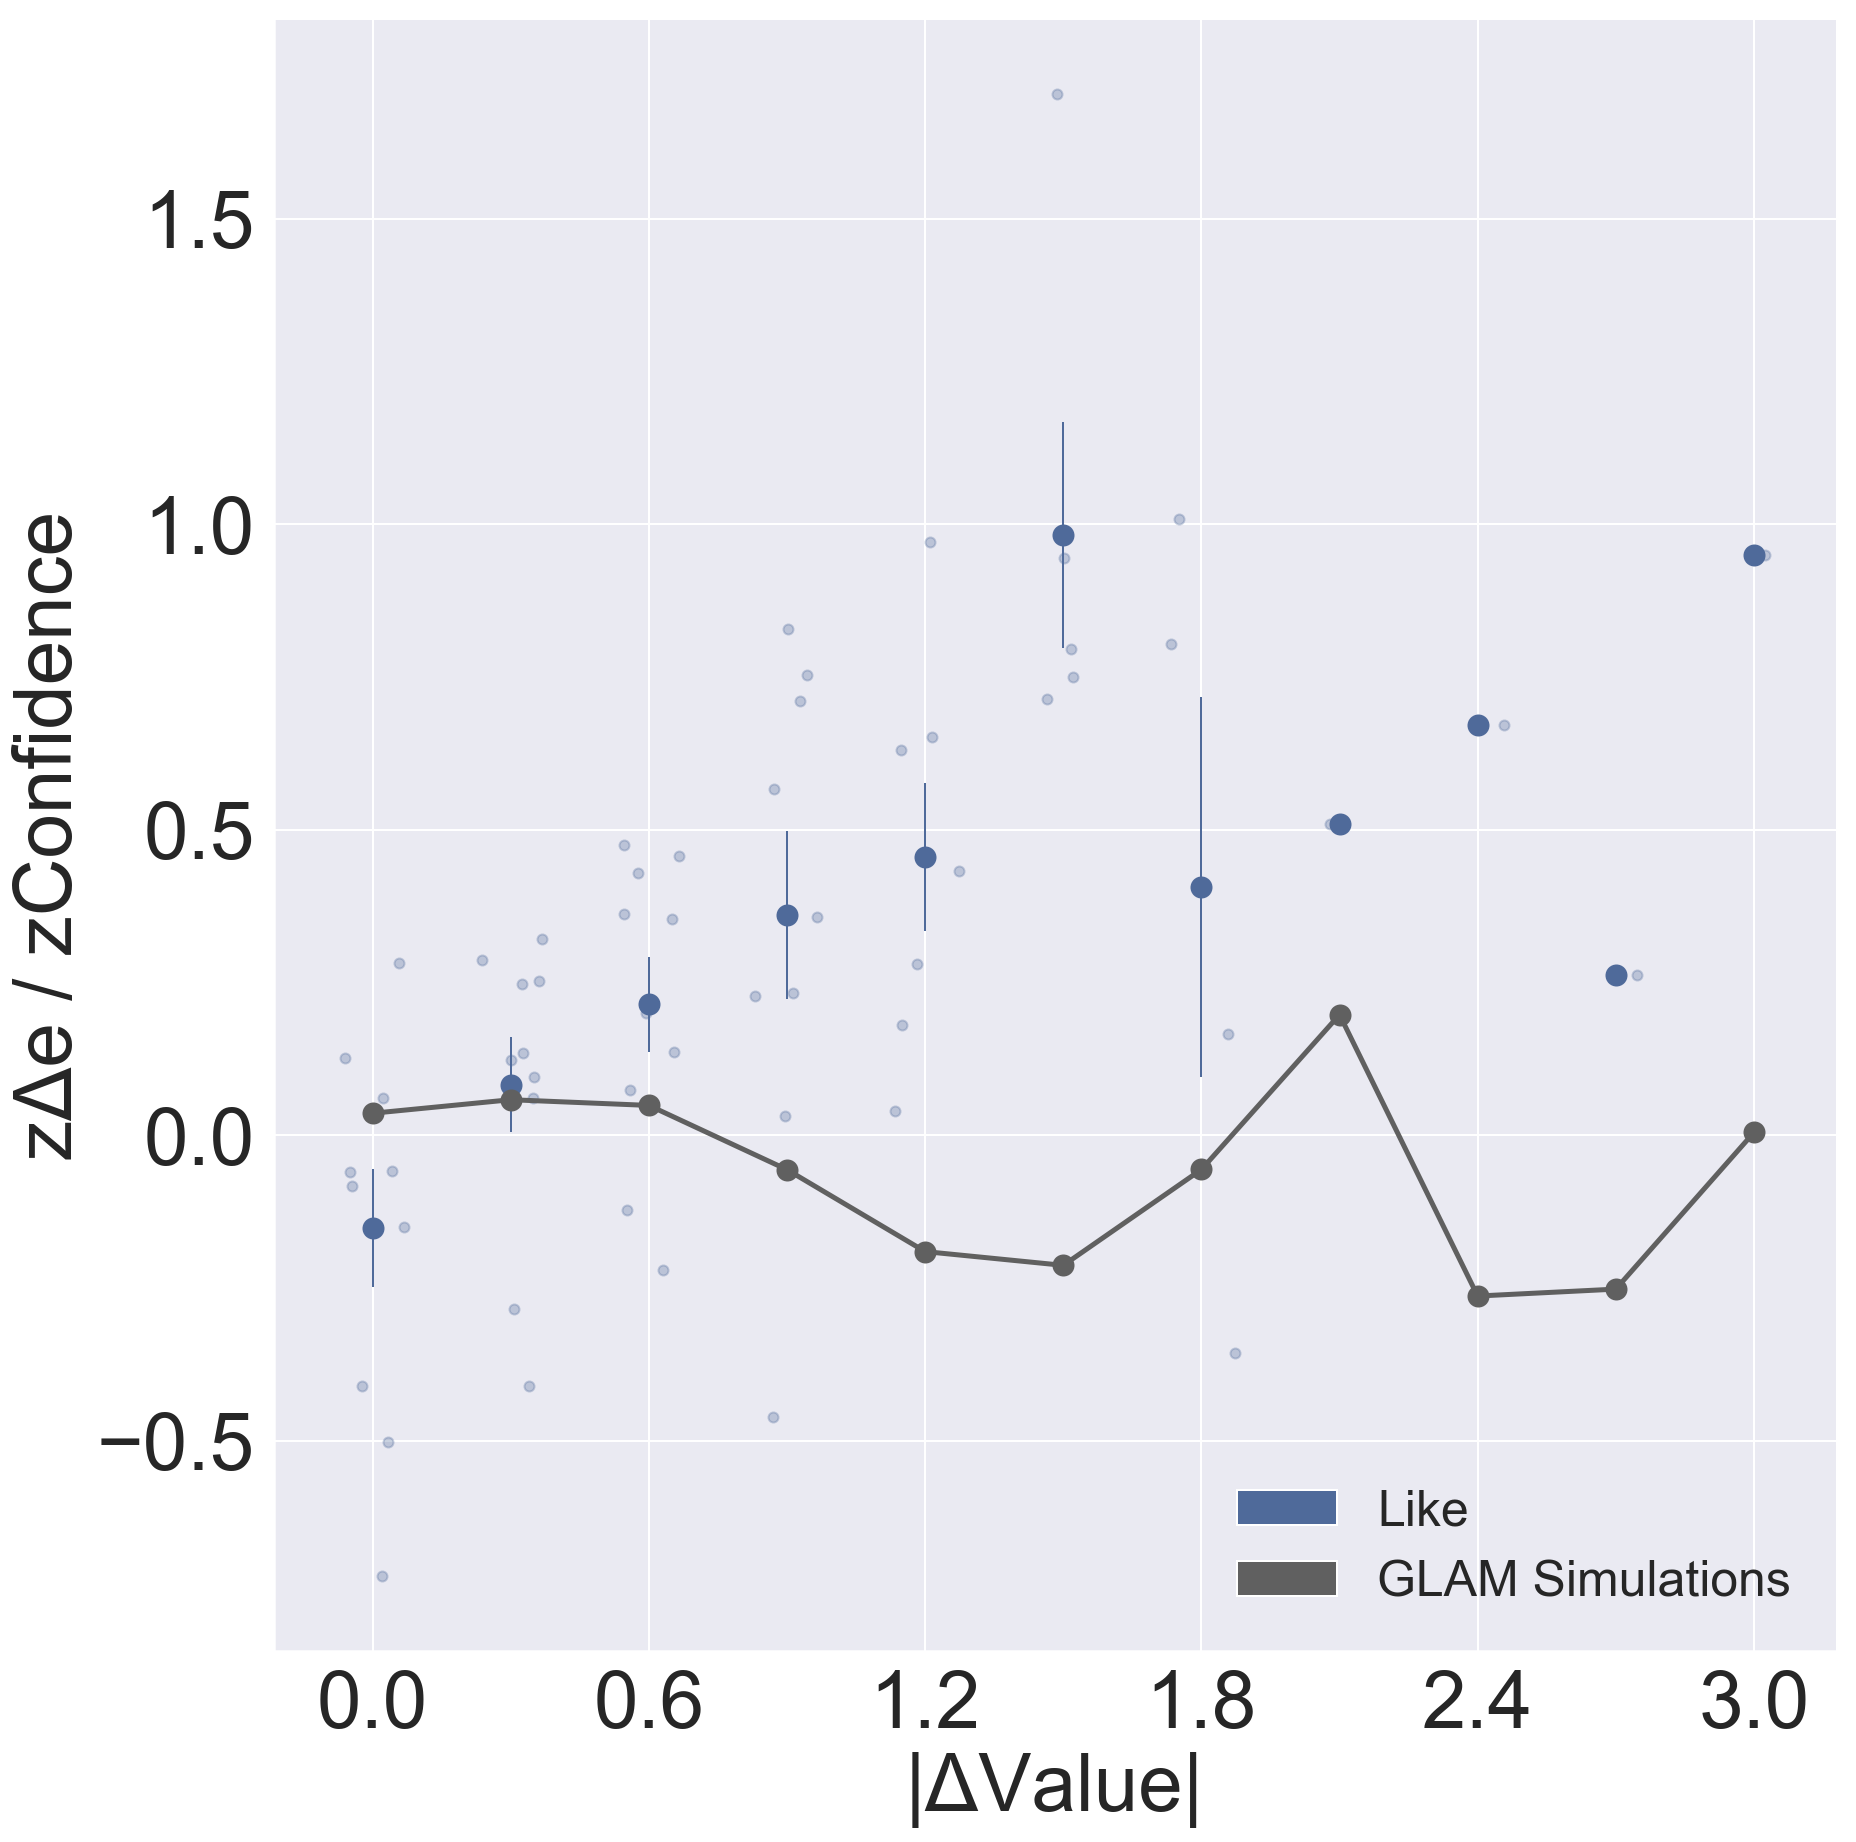

In [30]:
plot_DEv_Conf(data_simulation, xlabel_skip=2,color1 = '#4F6A9A')

Done with TotVal


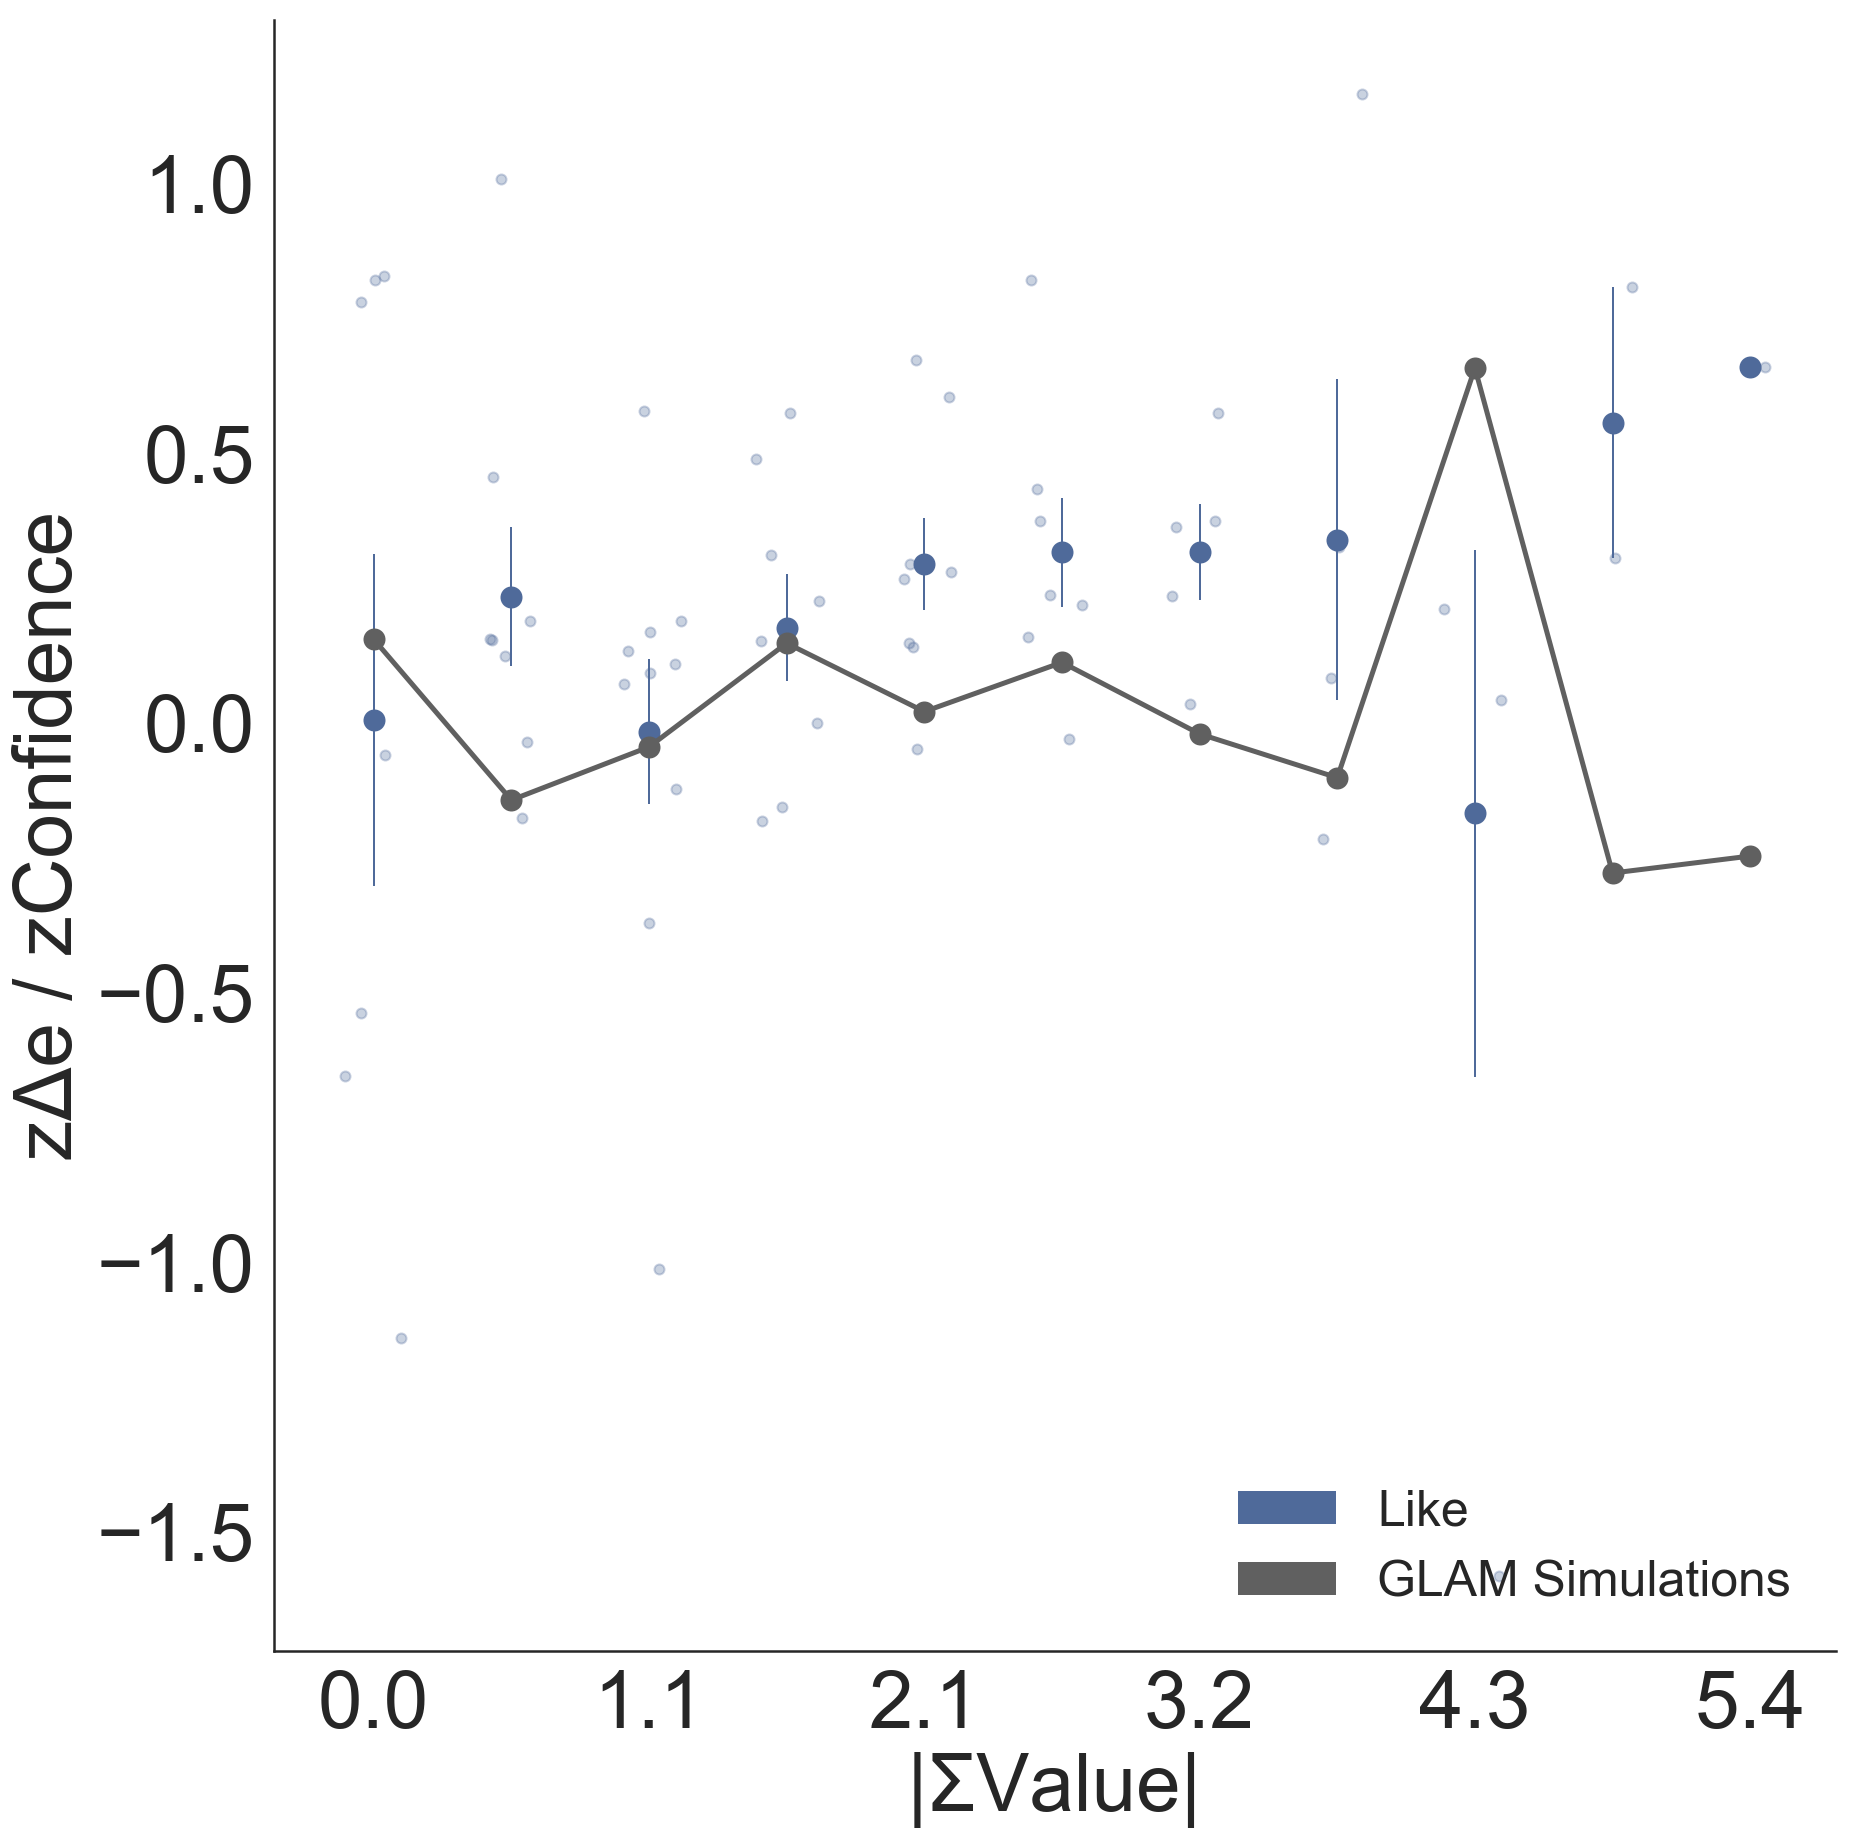

In [31]:
plot_DEv_Conf_TotVal(data_simulation,'TotVal', xlabel_skip=2,color1 = '#4F6A9A')

If we split by constant DVal...

## Relationship Total Value and DGaze, splitting for DV

In [ ]:

for i in range(5):
    data_GazeVal_extract = data_GazeVal.loc[data_GazeVal['zDVal_bin'] == i] # 1 = Like, 2 = Dislike
    print ('DVal = ' + str(i))
    correl_plot(data_GazeVal_extract,'zTotValue','zTotValue','AbsDGaze', "AbsDGaze") 

## Relationship Total Value and DGaze, splitting for AbsDV

In [ ]:

for i in range(5):
    data_GazeVal_extract = data_GazeVal.loc[data_GazeVal['zAbsDVal_bin'] == i] # 1 = Like, 2 = Dislike
    print ('DVal = ' + str(i))
    correl_plot(data_GazeVal_extract,'zTotValue','zTotValue','AbsDGaze', "AbsDGaze") 

We observe a (tiny) effect of Total Value over the magnitude in DGaze. That means that the bigger the difference in value also the magnitude of DGaze will increment. From the correlation above, we see that gaze tends to be aliged with the item of max value.
Therefore, in terms of accumulators, we have that the biggest the total value, the difference in gaze will increase favouring the item with higher value. Given the model, when the selected item is not fixated the rate of accumulation decreases keeping the rate of accumulation of the higher item. 

𝐴 = 𝑔 × 𝑟 + (1 − 𝑔 ) × 𝛾𝑟   

R*left = A_left - A_right   

R*right = A_right - A_left    

Then, the R* will get into the logistic regression to get the accumulation rate. However, given that tau is the same for all, is Rstar the one that should contain the TotValue effect over DEvidence.
The atenuation effect for DEvidence that we observe  for higher TotVal can be explained by the asintote that we have at the extremes of sigmoid function. 

Using mean gamma from params ( negative gamma) that means that there is a leak towards the non fixated item which should increase more the difference between the attended vs unattended item. (Leak: you are substracting evidence when the item is not attended)


In [ ]:
# No gaze bias
gamma_t= -0.2
gL_t=0.5
LItem_t = 3 
RItem_t = 2 
AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t

R_starR = AR_t - AL_t
R_starL = AL_t - AR_t
R_starL

Without gaze bias we don't observe an influence of TotalValue over the result. But if we include the gaze bias. We observe an increase in the magnitude of R*

# Generate HeatMap for R* (bigger R* means the difference between the accumulator rates will also be bigger)

## For equal gaze ration

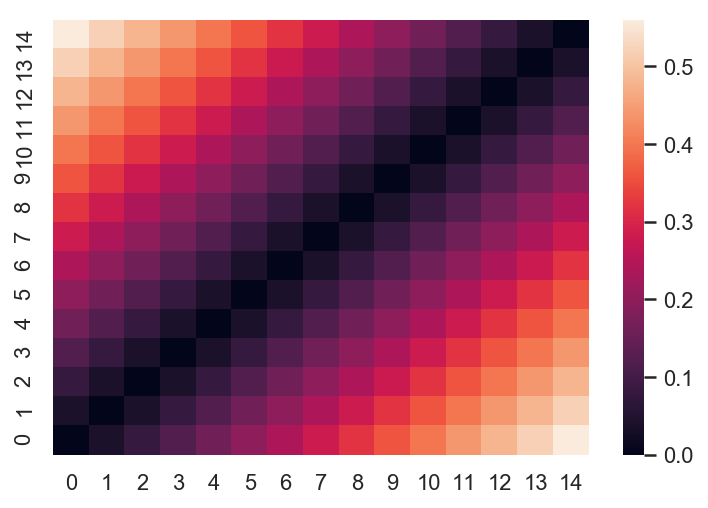

In [34]:
# Create DV data
x = range(0, 30,2)
y = range(0, 30,2)
# Keeping constant 
gL_t = 0.5
gamma_t = -0.2

Rstars_2dim = []
for i in range(len(x)):
    Rstars_1dim = []
    for j in range(len(y)):
        RItem_t = i *0.1
        LItem_t = j *0.1
        AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
        AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t
        R_star = abs (AR_t - AL_t)
        Rstars_1dim.append(R_star)
    Rstars_2dim.append(Rstars_1dim)
df = pd.DataFrame(Rstars_2dim)
df2 = df.reindex(index=df.index[::-1])
p1 = sns.heatmap(df2)

## For assymetric gaze ration

### A. Right more gaze 

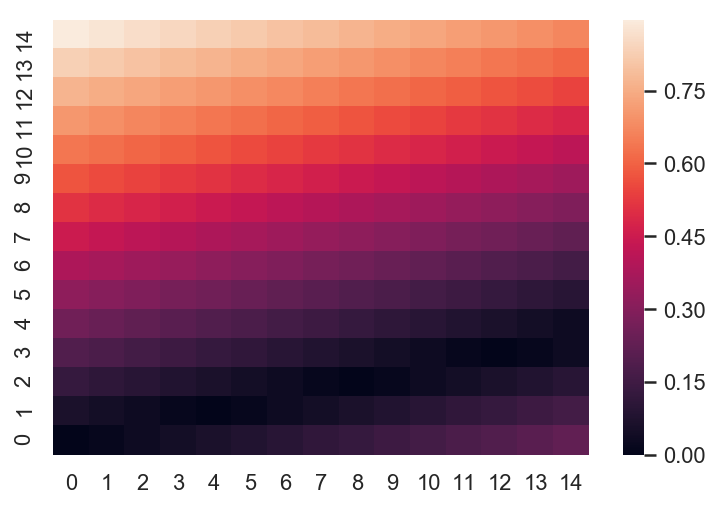

In [35]:
# Create DV data
x = range(0, 30,2)
y = range(0, 30,2)
# Keeping constant 
gL_t = 0.3
gamma_t = -0.2

Rstars_2dim = []
for i in range(len(x)):
    Rstars_1dim = []
    for j in range(len(y)):
        RItem_t = i *0.1
        LItem_t = j *0.1
        AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
        AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t
        R_star = abs (AR_t - AL_t)
        Rstars_1dim.append(R_star)
    Rstars_2dim.append(Rstars_1dim)
df = pd.DataFrame(Rstars_2dim)
df2 = df.reindex(index=df.index[::-1])
p1 = sns.heatmap(df2)

## B. Left more gaze

In [ ]:
# Create DV data
x = range(0, 30,2)
y = range(0, 30,2)
# Keeping constant 
gL_t = 0.7
gamma_t = -0.0

Rstars_2dim = []
for i in range(len(x)):
    Rstars_1dim = []
    for j in range(len(y)):
        RItem_t = i *0.1
        LItem_t = j *0.1
        AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
        AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t
        R_star = abs (AR_t - AL_t)
        Rstars_1dim.append(R_star)
    Rstars_2dim.append(Rstars_1dim)
df = pd.DataFrame(Rstars_2dim)
df2 = df.reindex(index=df.index[::-1])
p1 = sns.heatmap(df2)

## Changing the gamma value : equal gaze ratio

In [ ]:
order = 1
f = plt.figure(figsize=(30, 30))
for gama in range(-10,10):
    # Create DV data
    x = range(0, 30,2)
    y = range(0, 30,2)
    # Keeping constant 
    gL_t = 0.5
    gamma_t = gama*0.1
   # print ('gamma:' + str(gamma_t))
    
    Rstars_2dim = []
    for i in range(len(x)):
        Rstars_1dim = []
        for j in range(len(y)):
            RItem_t = i *0.1
            LItem_t = j *0.1
            AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
            AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t
            R_star = abs (AR_t - AL_t)
            Rstars_1dim.append(R_star)
        Rstars_2dim.append(Rstars_1dim)
    df = pd.DataFrame(Rstars_2dim)
    df2 = df.reindex(index=df.index[::-1])
    
    sub={}
    sub['%s' % order] = plt.subplot(int(len(range(-10,10))/5), 5, order)
    sub['%s' % order].set_title('gamma %s' % round(gamma_t,2))

    p1 = sns.heatmap(df2)
    
    order += 1
 
    sns.despine()

    
f.text(0.5, 0.0, 'Left Value', ha='center')
f.text(0.0, 0.5, 'Right Value', va='center', rotation='vertical')
plt.tight_layout()
    


## Changing the gamma value : left more gaze

In [ ]:
order = 1
f = plt.figure(figsize=(30, 30))
for gama in range(-10,10):
    # Create DV data
    x = range(0, 30,2)
    y = range(0, 30,2)
    # Keeping constant 
    gL_t = 0.7
    gamma_t = gama*0.1
   # print ('gamma:' + str(gamma_t))
    
    Rstars_2dim = []
    for i in range(len(x)):
        Rstars_1dim = []
        for j in range(len(y)):
            RItem_t = i *0.1
            LItem_t = j *0.1
            AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
            AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t
            R_star = abs (AR_t - AL_t)
            Rstars_1dim.append(R_star)
        Rstars_2dim.append(Rstars_1dim)
    df = pd.DataFrame(Rstars_2dim)
    df2 = df.reindex(index=df.index[::-1])
    
    sub={}
    sub['%s' % order] = plt.subplot(int(len(range(-10,10))/5), 5, order)
    sub['%s' % order].set_title('gamma %s' % round(gamma_t,2))

    p1 = sns.heatmap(df2)
    
    order += 1
    
    
   # x_labels = [round(0.1*ii,2) for ii in x]
   # y_labels = [round(0.1*jj,2) for jj in y]
   # plt.xticks(range(len(y)),y_labels)
   # plt.yticks(range(len(x)),x_labels)
   # sns.despine()

    
f.text(0.5, 0.0, 'Left Value', ha='center')
f.text(0.0, 0.5, 'Right Value', va='center', rotation='vertical')
plt.tight_layout()


## Changing gaze ratio

In [ ]:
order = 1
f = plt.figure(figsize=(30, 15))
for gaze in range(0,10):
    # Create DV data
    x = range(0, 30,2)
    y = range(0, 30,2)
    # Keeping constant 
    gL_t = gaze*0.1
    gamma_t = -0.2
   # print ('gamma:' + str(gamma_t))
    
    Rstars_2dim = []
    for i in range(len(x)):
        Rstars_1dim = []
        for j in range(len(y)):
            RItem_t = i *0.1
            LItem_t = j *0.1
            AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
            AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t
            R_star = abs (AR_t - AL_t)
            Rstars_1dim.append(R_star)
        Rstars_2dim.append(Rstars_1dim)
    df = pd.DataFrame(Rstars_2dim)
    df2 = df.reindex(index=df.index[::-1])
    
    sub={}
    sub['%s' % order] = plt.subplot(int(len(range(0,10))/5), 5, order)
    sub['%s' % order].set_title('Gaze Left %s' % round(gL_t,2))

    p1 = sns.heatmap(df2)
    
    order += 1
    sns.despine()

    
f.text(0.5, 0.0, 'Left Value', ha='center')
f.text(0.0, 0.5, 'Right Value', va='center', rotation='vertical')
plt.tight_layout()


We see how R* increases for higher total value even if we mantain the same DV, that means that the boost of evidence due to attention is real. 

distributions seemed strange for TotVal, but the real data has that shape

In [ ]:
data_simulation.hist(column='TotVal_orig')

In [ ]:
data_simulation.hist(column='TotVal')

In [ ]:
data_all.hist(column='DVal')
data_all.hist(column='TotVal')

# Confidence is linked to high value item??

In [ ]:
data_all.columns

In [ ]:
# add higher value
data_all["zHighVal"] = data_all[["zRVal", "zLVal"]].max(axis=1)
data_all2["zHighVal"] = data_all2[["zRVal", "zLVal"]].max(axis=1)

# add lower value
data_all["zLowVal"] = data_all[["zRVal", "zLVal"]].min(axis=1)
data_all2["zLowVal"] = data_all2[["zRVal", "zLVal"]].min(axis=1)

In [ ]:
data_all[['zLVal','zRVal','zHighVal','zLowVal']]

In [ ]:
%%R -i data_all -i data_all2
d <- data_all
d2 <- data_all2

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~ zHighVal + zLowVal + zTotVal + zConf  , data= d)
ModelDislike_1 <- glm(zConf ~ zHighVal + zLowVal  + zTotVal + zConf  , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5),main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)

#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~ zDVal + zRT + zTotVal + zGSF  , data= d)
ModelDislike_1 <- glm(zConf ~ zDVal + zRT + zTotVal + zGSF, data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5),main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~ zDVal + zRT + zTotVal + zGSF+ zHighVal + zLowVal  , data= d)
ModelDislike_1 <- glm(zConf ~ zDVal + zRT + zTotVal + zGSF + zHighVal + zLowVal   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5),main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

# Effect of separated High and Low (instead of TotVal) value over Confidence 

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~ zAbsDVal + zRT  + zGSF+ zTotVal    , data= d)
ModelDislike_1 <- glm(zConf ~ zAbsDVal + zRT  + zGSF + zTotVal   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)

legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~ zAbsDVal + zRT  + zGSF+ zHighVal + zLowVal    , data= d)
ModelDislike_1 <- glm(zConf ~ zAbsDVal + zRT  + zGSF + zHighVal + zLowVal   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~  zRT  + zGSF+ zHighVal + zLowVal    , data= d)
ModelDislike_1 <- glm(zConf ~ zRT  + zGSF + zHighVal + zLowVal   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~  zRT  + zGSF+ Correct + zHighVal + zLowVal    , data= d)
ModelDislike_1 <- glm(zConf ~  zRT  + zGSF + Correct + zHighVal + zLowVal   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

print(ModelLike_1)
print(ModelDislike_1)

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~  zRT  + zGSF+ Correct + zHighVal + zLowVal+ zHighVal:Correct + zLowVal:Correct    , data= d)
ModelDislike_1 <- glm(zConf ~  zRT  + zGSF + Correct + zHighVal + zLowVal+ zHighVal:Correct + zLowVal:Correct   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

print(ModelLike_1)
print(ModelDislike_1)

# Effect of DV over Reaction Time

In [ ]:
%%R    
title_plot = "Confidence"
ModelLike_1 <- glm(zConf ~ zAbsDVal  + zTotVal    , data= d)
ModelDislike_1 <- glm(zConf ~ zAbsDVal + zTotVal    , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, .5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "RT (human)"
ModelLike_1 <- glm(zRT ~ zAbsDVal  + zTotVal    , data= d)
ModelDislike_1 <- glm(zRT ~ zAbsDVal + zTotVal    , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.2, .2) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "RT (human)"
ModelLike_1 <- glm(zRT ~ zAbsDVal  + zGSF+ zTotVal    , data= d)
ModelDislike_1 <- glm(zRT ~ zAbsDVal   + zGSF + zTotVal    , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-1, 1) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "RT (human)"
ModelLike_1 <- glm(zRT ~ zAbsDVal  +zConf+ zGSF+ zTotVal    , data= d)
ModelDislike_1 <- glm(zRT ~ zAbsDVal +zConf  + zGSF + zTotVal    , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-1, 1) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "RT (human)"
ModelLike_1 <- glm(zRT ~ zConf+  zHighVal + zLowVal    , data= d)
ModelDislike_1 <- glm(zRT ~ zConf + zHighVal + zLowVal   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "RT (human)"
ModelLike_1 <- glm(zRT ~  zHighVal + zLowVal    , data= d)
ModelDislike_1 <- glm(zRT ~ zHighVal + zLowVal   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

## Effect of correct on RT

In [ ]:
%%R    
title_plot = "RT (human)"
ModelLike_1 <- glm(zRT ~ zAbsDVal  +Correct+  zTotVal + Correct:zTotVal   , data= d)
ModelDislike_1 <- glm(zRT ~ zAbsDVal +Correct + zTotVal + Correct:zTotVal    , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-.3, .3) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

print(ModelLike_1)
print(ModelDislike_1)

## Do we observe Total Value effect over confidence only when there is a difference in gaze? (considering only LIKE frame)

In [ ]:
data_GazeVal =  pd.DataFrame()
data_GazeVal["RGaze"] = data.gaze_1 
data_GazeVal["LGaze"] = data.gaze_0 
data_GazeVal["DGaze"] = data.gaze_1 - data.gaze_0
data_GazeVal["AbsDGaze"] = abs(data.gaze_1 - data.gaze_0)
data_GazeVal["zRValue"] = data_all.zRVal.values
data_GazeVal["zLValue"] = data_all.zLVal.values
data_GazeVal["zTotValue"] = data_all.zTotVal.values
data_GazeVal["zDValue"] = data_all.zDVal.values
data_GazeVal["zAbsDValue"] = data_all.zAbsDVal.values
data_GazeVal["DValue"] = data_all.DVal.values
data_GazeVal["zConf"] = data_all.zConf.values
data_GazeVal["zRT"] = data_all.zRT.values

In [ ]:
len(data_GazeVal["zDValue"].values)

# Add bin column for Value

In [ ]:
# data_GazeVal["zDVal_bin"] = pd.qcut(data_GazeVal["zDValue"].values, 10, labels=[0, 1, 2,3,4,5,6,7,8,9])
data_GazeVal["zDVal_bin"] = pd.to_numeric(pd.qcut(data_GazeVal["zDValue"].values, 3, labels=[0, 1, 2]))
data_GazeVal["zAbsDVal_bin"] = pd.to_numeric(pd.qcut(data_GazeVal["zAbsDValue"].values, 3, labels=[0, 1, 2]))

data_GazeVal["zHighVal"] = data_GazeVal[["zRValue", "zLValue"]].max(axis=1)

# Add bin column for Gaze

In [ ]:
# data_GazeVal["zDVal_bin"] = pd.qcut(data_GazeVal["zDValue"].values, 10, labels=[0, 1, 2,3,4,5,6,7,8,9])
data_GazeVal["zDGaze_bin"] = pd.to_numeric(pd.qcut(data_GazeVal["DGaze"].values, 5, labels=[0, 1, 2,3,4]))
data_GazeVal["zAbsDGaze_bin"] =pd.to_numeric( pd.qcut(data_GazeVal["AbsDGaze"].values, 5, labels=[0, 1, 2,3,4]))

data_GazeVal["zHighGaze"] = data_GazeVal[["RGaze", "LGaze"]].max(axis=1)

In [ ]:
data_GazeVal.head()

In [ ]:
%%R -i data_GazeVal 
d <- data_GazeVal

In [ ]:
%%R


d1 <- d[which(d$zAbsDGaze_bin== 0), ]
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~ zAbsDValue  + zTotValue +zRT  , data= d1)
coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-.5, .5),main=title_plot)

#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)

cat(" BIC Like: " , BIC1Like_1)

print(ModelLike_1)

## Add for the rest
x <- c(1,2,3,4)
colors <- c('blue','green','yellow','magenta')

for (i in x){
# Separating the data for both conditions 
d1 <- d[which(d$zDGaze_bin== i), ]

title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~ zAbsDValue  + zTotValue +zRT , data= d1)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE, add=TRUE ,col.pts=colors[i], cex.var=1.5, cex.pts=2, mar = c(8,4,7,5),main=title_plot)

legend("bottomleft",  legend=c("|DGaze|= 0", "|DGaze| =1","|DGaze|= 2",'|DGaze|= 3','|DGaze|= 4'),col=c("red", "blue",'green','yellow', 'magenta'), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)

cat(" BIC Like: " , BIC1Like_1)

print(ModelLike_1)
}

-----------------------

# Balance of evidence effect depending on gaze difference for simulations??

## Like simulations - gaze bias

In [ ]:
sufix = 'individual_Like_NoBin_Gamma-11_NUTS_31' # Like sufix
#sufix = 'individual_Dislike_Inv_NoBin_Gamma-11_NUTS_31' # Dislike sufix

data_simulation = pd.read_csv(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv'))


In [ ]:
data_simulation.head()

In [ ]:
data_GazeVal =  pd.DataFrame()
data_GazeVal["DGaze"] = data_simulation.RGaze - data_simulation.LGaze
data_GazeVal["AbsDGaze"] = abs(data_simulation.RGaze - data_simulation.LGaze)
data_GazeVal["zRValue"] = data_simulation.zRVal.values
data_GazeVal["zLValue"] = data_simulation.zLVal.values
data_GazeVal["zTotValue"] = data_simulation.zTotVal.values
#data_GazeVal["zDValue"] = data_all.zDVal.values
data_GazeVal["zAbsDValue"] = data_simulation.zAbsDVal.values
#data_GazeVal["DValue"] = data_simulation.DVal.values
data_GazeVal["zConf_human"] = data_simulation.zConf_human.values
data_GazeVal["zAbsDEv"] = data_simulation.zAbsDEv.values
data_GazeVal["zRTsim"] = data_simulation.zRTsim.values
data_GazeVal["Choice_sim"] = data_simulation.Choice_sim.values
data_GazeVal["zChoVal"] = data_GazeVal['zRValue']*data_GazeVal['Choice_sim']+ data_GazeVal['zLValue']*(1-data_GazeVal['Choice_sim'])
data_GazeVal["zUnchVal"] = data_GazeVal['zLValue']*data_GazeVal['Choice_sim']+ data_GazeVal['zRValue']*(1-data_GazeVal['Choice_sim'])


In [ ]:
# data_GazeVal["zDVal_bin"] = pd.qcut(data_GazeVal["zDValue"].values, 10, labels=[0, 1, 2,3,4,5,6,7,8,9])
data_GazeVal["zDGaze_bin"] = pd.to_numeric(pd.qcut(data_GazeVal["DGaze"].values, 5, labels=[0, 1, 2,3,4]))
data_GazeVal["zAbsDGaze_bin"] =pd.to_numeric( pd.qcut(data_GazeVal["AbsDGaze"].values, 5, labels=[0, 1, 2,3,4]))


In [ ]:
%%R -i data_GazeVal 
d <- data_GazeVal

In [ ]:
%%R

d1 <- d[which(d$zAbsDGaze_bin== 0), ]
title_plot = "|zDEv| - Simulations Like - WITH gaze asymetries"
ModelLike_1 <- glm(zAbsDEv ~ zAbsDValue  + zTotValue  + zRTsim, data= d1)
coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-.3, .3),main=title_plot)

#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)

cat(" BIC Like: " , BIC1Like_1)

print(ModelLike_1)

## Add for the rest
x <- c(1,2,3,4)
colors <- c('blue','green','yellow','magenta')

for (i in x){
# Separating the data for both conditions 
d1 <- d[which(d$zDGaze_bin== i), ]

title_plot = "Confidence (human)"
ModelLike_1 <- glm(zAbsDEv ~ zAbsDValue  + zTotValue  + zRTsim, data= d1)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE, add=TRUE ,col.pts=colors[i], cex.var=1.5, cex.pts=2, mar = c(8,4,7,5),main=title_plot)

legend("bottomleft",  legend=c("|DGaze|= 0", "|DGaze| =1","|DGaze|= 2",'|DGaze|= 3','|DGaze|= 4'),col=c("red", "blue",'green','yellow', 'magenta'), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)

cat(" BIC Like: " , BIC1Like_1)

print(ModelLike_1)
}

In [ ]:
%%R
#title
title_plot = ("|zDEv| - WITH gaze asymmetry")

Model <- glm(zAbsDEv ~  zChoVal + zUnchVal , data=d)

BIC1 = BIC(Model)
print("Like BIC:")
print(BIC1)

coefplot(Model, intercept=FALSE, vertical = FALSE, col.pts="blue", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
summary(Model)$coefficients


In [ ]:
%%R

d1 <- d[which(d$zAbsDGaze_bin== 0), ]
title_plot = "|zDEv| - Simulations Like - WITH gaze asymetries"
ModelLike_1 <- glm(zAbsDEv ~  zChoVal + zUnchVal, data= d1)
coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-.3, .3),main=title_plot)

#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)

cat(" BIC Like: " , BIC1Like_1)

print(ModelLike_1)

## Add for the rest
x <- c(1,2,3,4)
colors <- c('blue','green','yellow','magenta')

for (i in x){
# Separating the data for both conditions 
d1 <- d[which(d$zDGaze_bin== i), ]

title_plot = "Confidence (human)"
ModelLike_1 <- glm(zAbsDEv ~  zChoVal + zUnchVal, data= d1)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE, add=TRUE ,col.pts=colors[i], cex.var=1.5, cex.pts=2, mar = c(8,4,7,5),main=title_plot)

legend("bottomleft",  legend=c("|DGaze|= 0", "|DGaze| =1","|DGaze|= 2",'|DGaze|= 3','|DGaze|= 4'),col=c("red", "blue",'green','yellow', 'magenta'), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)

cat(" BIC Like: " , BIC1Like_1)

print(ModelLike_1)
}

## Like simulations - NO gaze bias

In [ ]:
sufix = 'individual_Like_NoBin_Gamma-11_NUTS_31'
data_simulation = pd.read_csv(str('results/simulations_evidence/DEvidence_simulations_NoGaze_'+sufix+'.csv'))

In [ ]:
data_GazeVal =  pd.DataFrame()
data_GazeVal["DGaze"] = data_simulation.RGaze - data_simulation.LGaze
data_GazeVal["AbsDGaze"] = abs(data_simulation.RGaze - data_simulation.LGaze)
data_GazeVal["zRValue"] = data_simulation.zRVal.values
data_GazeVal["zLValue"] = data_simulation.zLVal.values
data_GazeVal["zTotValue"] = data_simulation.zTotVal.values
#data_GazeVal["zDValue"] = data_all.zDVal.values
data_GazeVal["zAbsDValue"] = data_simulation.zAbsDVal.values
#data_GazeVal["DValue"] = data_simulation.DVal.values
data_GazeVal["zConf_human"] = data_simulation.zConf_human.values
data_GazeVal["zAbsDEv"] = data_simulation.zAbsDEv.values
data_GazeVal["zRTsim"] = data_simulation.zRTsim.values
data_GazeVal["Choice_sim"] = data_simulation.Choice_sim.values
data_GazeVal["zChoVal"] = data_GazeVal['zRValue']*data_GazeVal['Choice_sim']+ data_GazeVal['zLValue']*(1-data_GazeVal['Choice_sim'])
data_GazeVal["zUnchVal"] = data_GazeVal['zLValue']*data_GazeVal['Choice_sim']+ data_GazeVal['zRValue']*(1-data_GazeVal['Choice_sim'])


 no gaze asymmetry in this dataset

In [ ]:
data_GazeVal.AbsDGaze.unique()

In [ ]:
data_GazeVal.head()

In [ ]:
%%R -i data_GazeVal 
d <- data_GazeVal

In [ ]:
%%R

title_plot = "|zDEv| - Simulations Like - WITHOUT gaze asymetry"
ModelLike_1 <- glm(zAbsDEv ~ zAbsDValue  + zTotValue  + zRTsim, data= d)
coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-.3, .3),main=title_plot)

#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)

In [ ]:
%%R
#title
title_plot = ("|zDEv| - WITHOUT gaze asymmetry")

Model <- glm(zAbsDEv ~  zChoVal + zUnchVal , data=d)

BIC1 = BIC(Model)
print("Like BIC:")
print(BIC1)

coefplot(Model, intercept=FALSE, vertical = FALSE, col.pts="blue", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
summary(Model)$coefficients


## Dislike simulations - gaze bias

In [ ]:
#sufix = 'individual_Like_NoBin_Gamma-11_NUTS_31' # Like sufix
sufix = 'individual_Dislike_Inv_NoBin_Gamma-11_NUTS_31' # Dislike sufix

data_simulation = pd.read_csv(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv'))

In [ ]:
data_simulation.head()

## Replace inv values to original in dislike frame

In [ ]:
data_GazeVal =  pd.DataFrame()
data_GazeVal["DGaze"] = data_simulation.RGaze - data_simulation.LGaze
data_GazeVal["AbsDGaze"] = abs(data_simulation.RGaze - data_simulation.LGaze)

data_GazeVal["Part"] = data_simulation.Part

data_GazeVal["LValue"] = 3- data_simulation.LVal
data_GazeVal["RValue"] = 3 - data_simulation.RVal
data_GazeVal["TotValue"] = data_GazeVal.RValue + data_GazeVal.LValue
data_GazeVal['zLValue'] = z_score1(data_GazeVal, 'Part','LValue')
data_GazeVal['zRValue'] = z_score1(data_GazeVal, 'Part','RValue')
data_GazeVal['zTotValue'] = z_score1(data_GazeVal, 'Part','TotValue')

#data_GazeVal["zRValue"] = data_simulation.zRVal.values
#data_GazeVal["zLValue"] = data_simulation.zLVal.values
#data_GazeVal["zTotValue"] = data_simulation.zTotVal.values
#data_GazeVal["zDValue"] = data_all.zDVal.values
data_GazeVal["zAbsDValue"] = data_simulation.zAbsDVal.values
#data_GazeVal["DValue"] = data_simulation.DVal.values
data_GazeVal["zConf_human"] = data_simulation.zConf_human.values
data_GazeVal["zAbsDEv"] = data_simulation.zAbsDEv.values
data_GazeVal["zRTsim"] = data_simulation.zRTsim.values
data_GazeVal["Choice_sim"] = data_simulation.Choice_sim.values


data_GazeVal["zChoVal"] = data_GazeVal['zRValue']*data_GazeVal['Choice_sim']+ data_GazeVal['zLValue']*(1-data_GazeVal['Choice_sim'])
data_GazeVal["zUnchVal"] = data_GazeVal['zLValue']*data_GazeVal['Choice_sim']+ data_GazeVal['zRValue']*(1-data_GazeVal['Choice_sim'])


In [ ]:
# data_GazeVal["zDVal_bin"] = pd.qcut(data_GazeVal["zDValue"].values, 10, labels=[0, 1, 2,3,4,5,6,7,8,9])
data_GazeVal["zDGaze_bin"] = pd.to_numeric(pd.qcut(data_GazeVal["DGaze"].values, 5, labels=[0, 1, 2,3,4]))
data_GazeVal["zAbsDGaze_bin"] =pd.to_numeric( pd.qcut(data_GazeVal["AbsDGaze"].values, 5, labels=[0, 1, 2,3,4]))


In [ ]:
%%R -i data_GazeVal 
d <- data_GazeVal

In [ ]:
%%R

d1 <- d[which(d$zAbsDGaze_bin== 0), ]
title_plot = "|zDEv| - Simulations Dislike - WITH gaze asymetries"
ModelLike_1 <- glm(zAbsDEv ~ zAbsDValue  + zTotValue  + zRTsim, data= d1)
coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-.3, .3),main=title_plot)

#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)

cat(" BIC Like: " , BIC1Like_1)

print(ModelLike_1)

## Add for the rest
x <- c(1,2,3,4)
colors <- c('blue','green','yellow','magenta')

for (i in x){
# Separating the data for both conditions 
d1 <- d[which(d$zDGaze_bin== i), ]

title_plot = "Confidence (human)"
ModelLike_1 <- glm(zAbsDEv ~ zAbsDValue  + zTotValue  + zRTsim, data= d1)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE, add=TRUE ,col.pts=colors[i], cex.var=1.5, cex.pts=2, mar = c(8,4,7,5),main=title_plot)

legend("bottomleft",  legend=c("|DGaze|= 0", "|DGaze| =1","|DGaze|= 2",'|DGaze|= 3','|DGaze|= 4'),col=c("red", "blue",'green','yellow', 'magenta'), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)

cat(" BIC Like: " , BIC1Like_1)

print(ModelLike_1)
}

In [ ]:
%%R
#title
title_plot = ("|zDEv| - Dislike WITH gaze asymmetry")

Model <- glm(zAbsDEv ~  zChoVal + zUnchVal , data=d)

BIC1 = BIC(Model)
print("Like BIC:")
print(BIC1)

coefplot(Model, intercept=FALSE, vertical = FALSE, col.pts="blue", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
summary(Model)$coefficients


In [ ]:
%%R

d1 <- d[which(d$zAbsDGaze_bin== 0), ]
title_plot = "|zDEv| - Simulations Dislike - WITH gaze asymetries"
ModelLike_1 <- glm(zAbsDEv ~  zChoVal + zUnchVal, data= d1)
coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-.3, .3),main=title_plot)

#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)

cat(" BIC Like: " , BIC1Like_1)

print(ModelLike_1)

## Add for the rest
x <- c(1,2,3,4)
colors <- c('blue','green','yellow','magenta')

for (i in x){
# Separating the data for both conditions 
d1 <- d[which(d$zDGaze_bin== i), ]

title_plot = "Confidence (human)"
ModelLike_1 <- glm(zAbsDEv ~  zChoVal + zUnchVal, data= d1)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE, add=TRUE ,col.pts=colors[i], cex.var=1.5, cex.pts=2, mar = c(8,4,7,5),main=title_plot)

legend("bottomright",  legend=c("|DGaze|= 0", "|DGaze| =1","|DGaze|= 2",'|DGaze|= 3','|DGaze|= 4'),col=c("red", "blue",'green','yellow', 'magenta'), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)

cat(" BIC Like: " , BIC1Like_1)

print(ModelLike_1)
}